# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Applying Decision Trees

## Applying Decision Trees on BOW

In [2]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning :Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:43<00:00, 2026.09it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


## Sorting the data in descending order beased on Time Column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [17]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
63160,68621,B005IOXBY0,A1ORVAUR5C5N8X,amondigirl,0,0,1,1351209600,WOW.....,This chocolate is amazing..I love the taste an...,chocolate amazing love taste smell chocolate f...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
86066,93711,B001NZPFB0,A3318V6FJ2KIII,T. Dennis,0,0,1,1351209600,My dog enjoys it and it helps her hips.,My dog was diagnosed with hip dysplasia as a 6...,dog diagnosed hip dysplasia old puppy vet said...
30235,32932,B001P05K8Q,A3L0B5NBTQ7ZHO,Julie,0,0,1,1351209600,Great results but they stink,We originally purchased these chews from our v...,originally purchased chews veterinarian decide...
96778,105165,B005EF0HZ4,A2A5Z7LC91EFVA,Gretchen Casey,0,0,1,1351209600,Gluten Free Kid,We LOVE Lucy's cookies! The Maple Bliss are w...,love lucy cookies maple bliss wonderful bad ha...
96779,105166,B005EF0HZ4,A1JXSMYVHFPWM1,marsha m beers,0,0,0,1351209600,Disappointed,I have not been able to find the Maple flavor ...,not able find maple flavor cookies area anywhe...
39050,42397,B0014DXT5A,AZUCLRMHEBUG0,"T. HANLEY ""reader""",0,0,1,1351209600,ZipFizz liquid energy shot,Have used this for years. Gives long lasting ...,used years gives long lasting energy boost no ...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...


In [18]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [19]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
1005,partner happy tea feeling much better since st...,1
63160,chocolate amazing love taste smell chocolate f...,1
9513,one finest maple syrups ordered enjoyed bought...,1
86066,dog diagnosed hip dysplasia old puppy vet said...,1


In [20]:
final_df.shape

(87773, 2)

In [21]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [22]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=3,shuffle=False) 
X_train, X_cv, y_train, y_cv= train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) 

In [23]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(56174,) (56174,)
(14044,) (14044,)
(17555,) (17555,)


In [24]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(56174, 43903) (56174,)
(14044, 43903) (14044,)
(17555, 43903) (17555,)


## Hyperparameter tuning to find best "depth" and 'min_samples_split"' using RandomizedSearchCV

In [53]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]
params_grid=dict(max_depth=depth,min_samples_split=min_samples_split)

In [54]:
params_grid

{'max_depth': [1, 5, 10, 50, 100, 500, 1000],
 'min_samples_split': [5, 10, 100, 500]}

In [55]:
# Estimator

from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced',random_state=3)

In [56]:
# Building RandomizedsSearchCV

DT_RandomCV=RandomizedSearchCV(DT,params_grid,cv=5,n_iter=30,scoring='roc_auc',n_jobs=-1)
DT_RandomCV.fit(X_train_bow,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=3,
                                                    splitter='bes

In [57]:
# Finding best parameters
DT_RandomCV.best_params_

{'min_samples_split': 500, 'max_depth': 50}

## Building Decision Tree using best the parameters

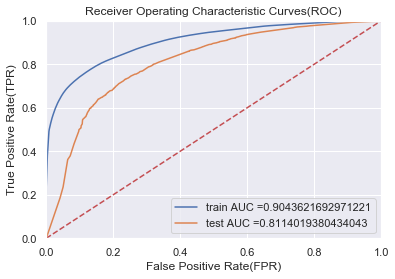

In [58]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(max_depth=50,min_samples_split=500,class_weight='balanced',random_state=2)
DT.fit(X_train_bow,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  DT.predict_proba(X_train_bow)[:,1]
y_cv_pred =  DT.predict_proba(X_cv_bow)[:,1]
y_test_pred=DT.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, DT.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, DT.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting Confusion matrix using seaborn

In [59]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [60]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6746349349198928 for threshold 0.49

Train confusion matrix:

[[ 8398  1425]
 [ 9775 36576]]

Test confusion matrix:

[[ 1525   642]
 [ 3411 11977]]


In [61]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

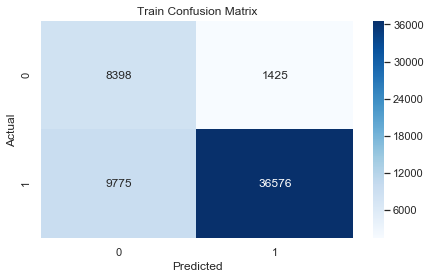

In [62]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

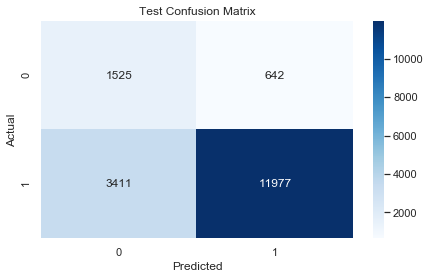

In [63]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Top 20 important features 

In [64]:
features=DT.feature_importances_

In [65]:
features

array([0., 0., 0., ..., 0., 0., 0.])

In [66]:
len(features)

43903

In [67]:
Top20_features=features.argsort()
Top20_features

array([    0, 29177, 29178, ...,  9975, 16694, 25849], dtype=int64)

In [68]:
#Finding top 20 features of Positive Class
Top20_features=Top20_features[-20:]
Top20_features

array([11948, 24510, 40828, 39151, 43217,  2604, 43097,  2727, 13153,
       13843, 25568, 22456, 16353, 28181, 22440, 10787,  3545,  9975,
       16694, 25849], dtype=int64)

In [69]:
# printing the top 20 positive feature names

print(np.take(vectorizer.get_feature_names(),Top20_features))

['easy' 'money' 'unfortunately' 'thought' 'worst' 'awful' 'wonderful'
 'bad' 'excellent' 'favorite' 'nice' 'loves' 'good' 'perfect' 'love'
 'disappointed' 'best' 'delicious' 'great' 'not']


In [70]:
Top20_features_Names=np.take(vectorizer.get_feature_names(),Top20_features)

In [71]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [72]:
Top20_features=Top20_features.head(20)

In [73]:
Top20_features['feature_names']=Top20_features_Names

In [74]:
Top20_features

,Indices,feature_names
5,2604,easy
7,2727,money
16,3545,unfortunately
17,9975,thought
15,10787,worst
0,11948,awful
8,13153,wonderful
9,13843,bad
12,16353,excellent
18,16694,favorite


In [75]:
All_features=vectorizer.get_feature_names()

###  Graphviz visualization of Decision Tree on BOW

In [76]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import graphviz
from sklearn import tree

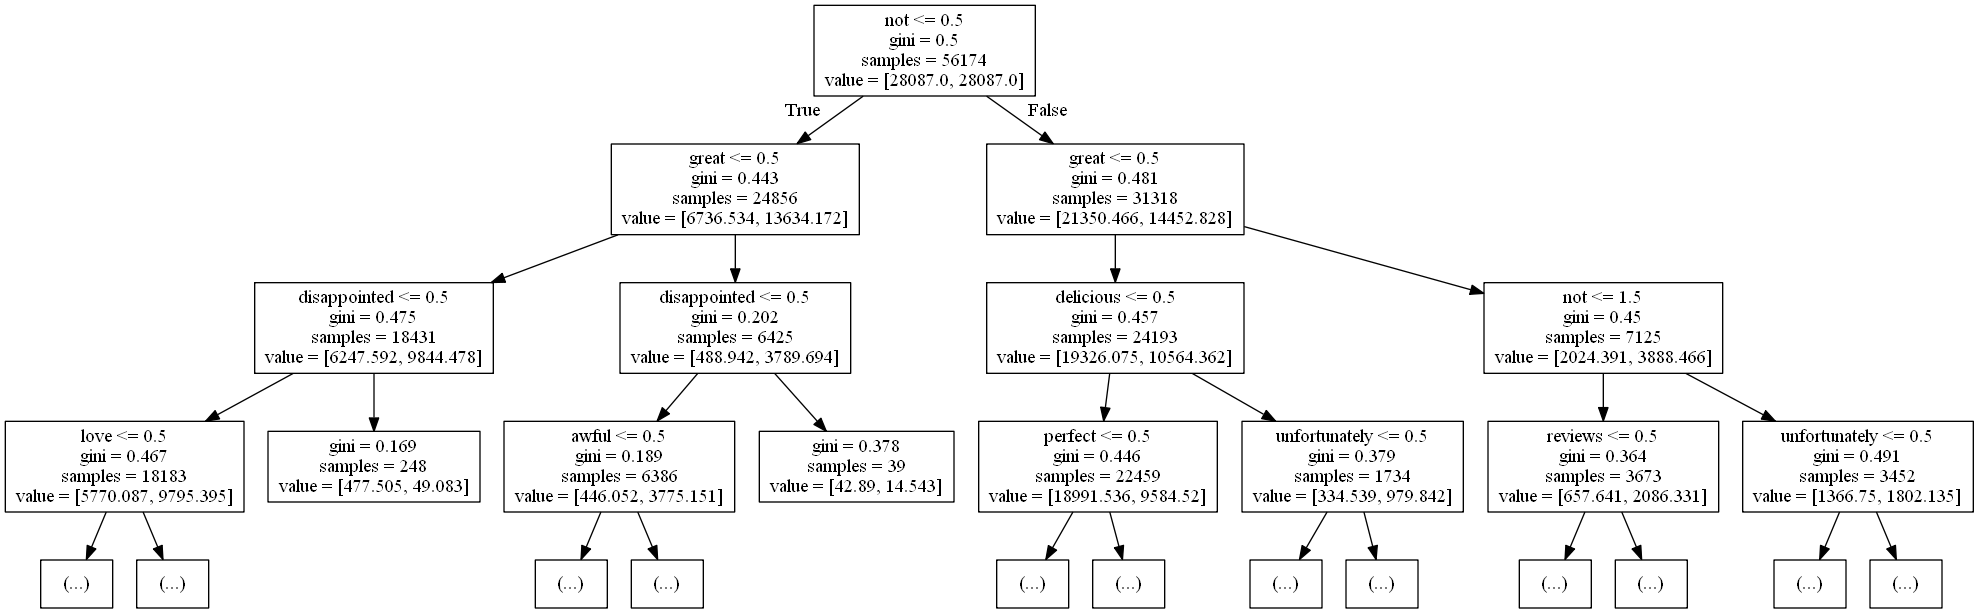

In [78]:
# Create DOT data
dot_data =tree.export_graphviz(decision_tree=DT, out_file = None,max_depth=3, feature_names = All_features)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())



In [79]:
# Create png

graph.write_png("graphviz_BOW.png")

True

## Applying Decision Trees on TFIDF

In [80]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l1')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(56174, 500) (56174,)
(14044, 500) (14044,)
(17555, 500) (17555,)


## Hyperparameter tuning to find best "depth" and 'min_samples_split"' using RandomizedSearchCV

In [81]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]
params_grid=dict(max_depth=depth,min_samples_split=min_samples_split)

In [83]:
# Estimator

from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced',random_state=4)

In [84]:
# Building RandomizedsSearchCV

DT_RandomCV=RandomizedSearchCV(DT,params_grid,cv=5,n_iter=30,scoring='roc_auc',n_jobs=-1)
DT_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=4,
                                                    splitter='bes

In [85]:
# Finding best parameters
DT_RandomCV.best_params_

{'min_samples_split': 500, 'max_depth': 50}

## Building Decision Tree using best parameters

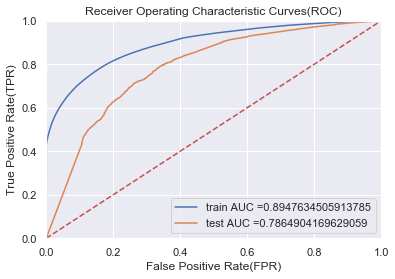

In [99]:
from sklearn.tree import DecisionTreeClassifier
DT_tfidf=DecisionTreeClassifier(max_depth=50,min_samples_split=500,class_weight='balanced',random_state=4)
DT_tfidf.fit(X_train_tfidf,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  DT_tfidf.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  DT_tfidf.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=DT_tfidf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, DT_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, DT_tfidf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting Confusion Matrix using seaborn

In [100]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6565105827220462 for threshold 0.488

Train confusion matrix:

[[ 8159  1664]
 [ 9715 36636]]

Test confusion matrix:

[[ 1457   710]
 [ 3474 11914]]


In [101]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

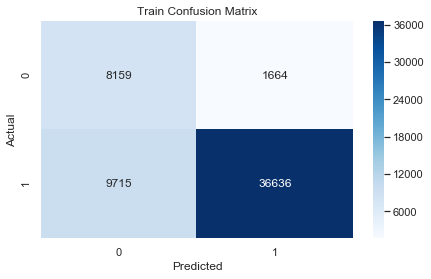

In [102]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

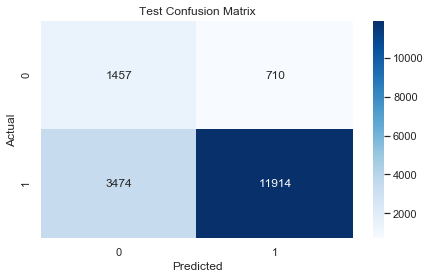

In [103]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Top 20 important features

In [104]:
features_tfidf=DT_tfidf.feature_importances_

In [105]:
Top20_features=features_tfidf.argsort()


In [106]:
#Finding top 20 features of Positive Class
Top20_features=Top20_features[-20:]
Top20_features

array([ 26, 452, 351, 217, 493, 489, 284, 164, 153, 297, 266, 333,  30,
       199,  38, 264, 120, 125, 202, 301], dtype=int64)

In [107]:
# printing the top 20 positive feature names

print(np.take(tf_idf_vect.get_feature_names(),Top20_features))

['away' 'thought' 'product' 'highly' 'would' 'wonderful' 'money'
 'favorite' 'excellent' 'nice' 'loves' 'perfect' 'bad' 'good' 'best'
 'love' 'delicious' 'disappointed' 'great' 'not']


In [108]:
Top20_features_Names=np.take(tf_idf_vect.get_feature_names(),Top20_features)

In [109]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [110]:
Top20_features=Top20_features.head(20)

In [111]:
Top20_features['feature_names']=Top20_features_Names

In [112]:
Top20_features

,Indices,feature_names
0,26,away
12,30,thought
14,38,product
16,120,highly
17,125,would
8,153,wonderful
7,164,money
13,199,favorite
18,202,excellent
3,217,nice


In [113]:
All_features_tfidf=tf_idf_vect.get_feature_names()

### Graphviz visualization of Decision Tree on TFIDF

In [114]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import graphviz
from sklearn import tree

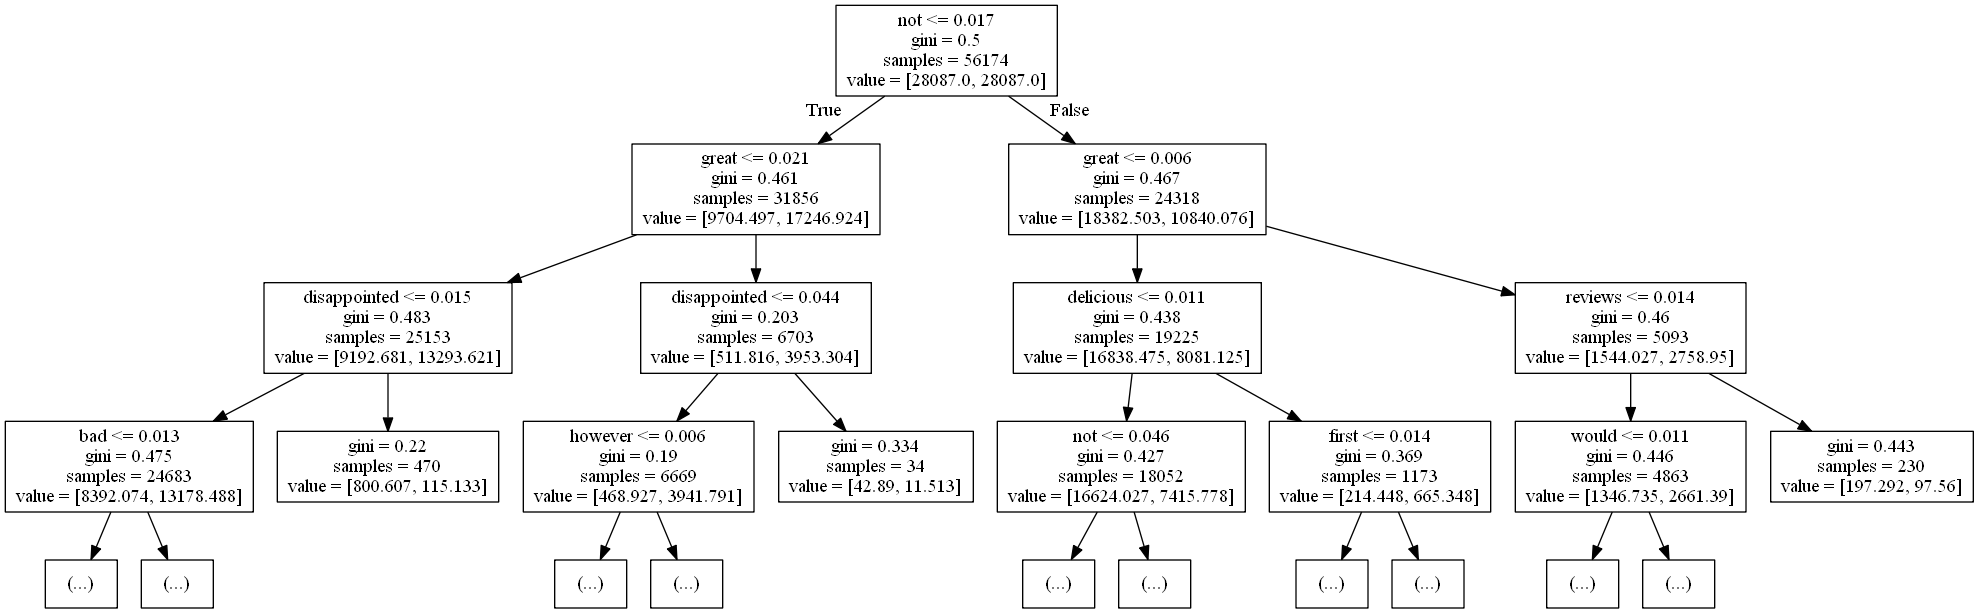

In [115]:
# Create DOT data
dot_data =tree.export_graphviz(decision_tree=DT_tfidf, out_file = None,max_depth=3, feature_names = All_features_tfidf)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())



In [116]:
# Create png

graph.write_png("graphviz_tfidf_L1.png")

True

In [117]:
## TFIDF on L2 regularization

tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l2')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(56174, 500) (56174,)
(14044, 500) (14044,)
(17555, 500) (17555,)


## Hyperparameter tuning to find best "depth" and 'min_samples_split"' using RandomizedSearchCV

In [118]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]
params_grid=dict(max_depth=depth,min_samples_split=min_samples_split)

In [119]:
# Estimator

from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced',random_state=5)

In [120]:
# Building RandomizedsSearchCV

DT_RandomCV=RandomizedSearchCV(DT,params_grid,cv=5,n_iter=30,scoring='roc_auc',n_jobs=-1)
DT_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=5,
                                                    splitter='bes

In [121]:
# Finding best parameters
DT_RandomCV.best_params_

{'min_samples_split': 500, 'max_depth': 50}

## Building Decision Tree using best the parameters

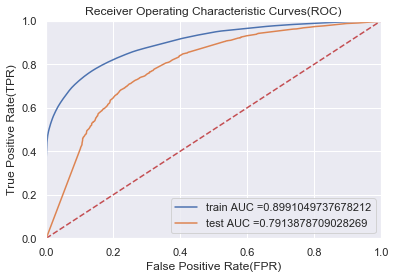

In [122]:
from sklearn.tree import DecisionTreeClassifier
DT_tfidf_L2=DecisionTreeClassifier(max_depth=50,min_samples_split=500,class_weight='balanced',random_state=4)
DT_tfidf_L2.fit(X_train_tfidf,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  DT_tfidf_L2.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  DT_tfidf_L2.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=DT_tfidf_L2.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, DT_tfidf_L2.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, DT_tfidf_L2.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



In [123]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6649226332294641 for threshold 0.479

Train confusion matrix:

[[ 8410  1413]
 [10353 35998]]

Test confusion matrix:

[[ 1499   668]
 [ 3648 11740]]


In [124]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

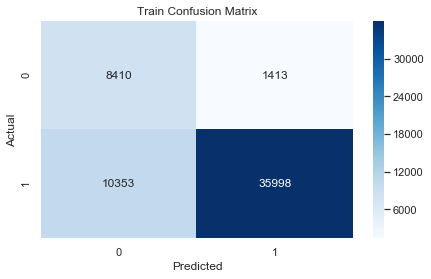

In [125]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

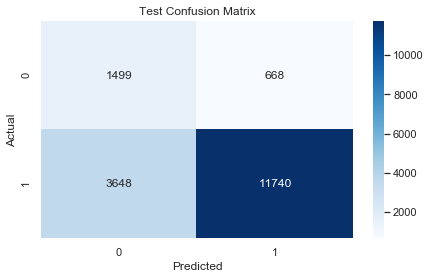

In [126]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

In [142]:
## Top 20 features of tfidf with L2 regularization

features_tfidf_L2=DT_tfidf_L2.feature_importances_

In [143]:
Top20_features=features_tfidf_L2.argsort()


In [144]:
#Finding top 20 features of Positive Class
Top20_features=Top20_features[-20:]
Top20_features

array([210,  14, 440, 135, 284, 489, 164, 153, 452,  30, 297, 266, 333,
       199,  38, 264, 125, 120, 202, 301], dtype=int64)

In [145]:
# printing the top 20 positive feature names

print(np.take(tf_idf_vect.get_feature_names(),Top20_features))

['happy' 'amazing' 'tasty' 'easy' 'money' 'wonderful' 'favorite'
 'excellent' 'thought' 'bad' 'nice' 'loves' 'perfect' 'good' 'best' 'love'
 'disappointed' 'delicious' 'great' 'not']


In [146]:
Top20_features_Names=np.take(tf_idf_vect.get_feature_names(),Top20_features)

In [147]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [148]:
Top20_features=Top20_features.head(20)

In [149]:
Top20_features['feature_names']=Top20_features_Names

In [150]:
Top20_features

,Indices,feature_names
1,14,happy
9,30,amazing
14,38,tasty
17,120,easy
16,125,money
3,135,wonderful
7,153,favorite
6,164,excellent
13,199,thought
18,202,bad


In [151]:
All_features_tfidf_L2=tf_idf_vect.get_feature_names()

In [152]:
## Graphviz visualization of Decision Tree on tfidf :L2 regularization

from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import graphviz
from sklearn import tree

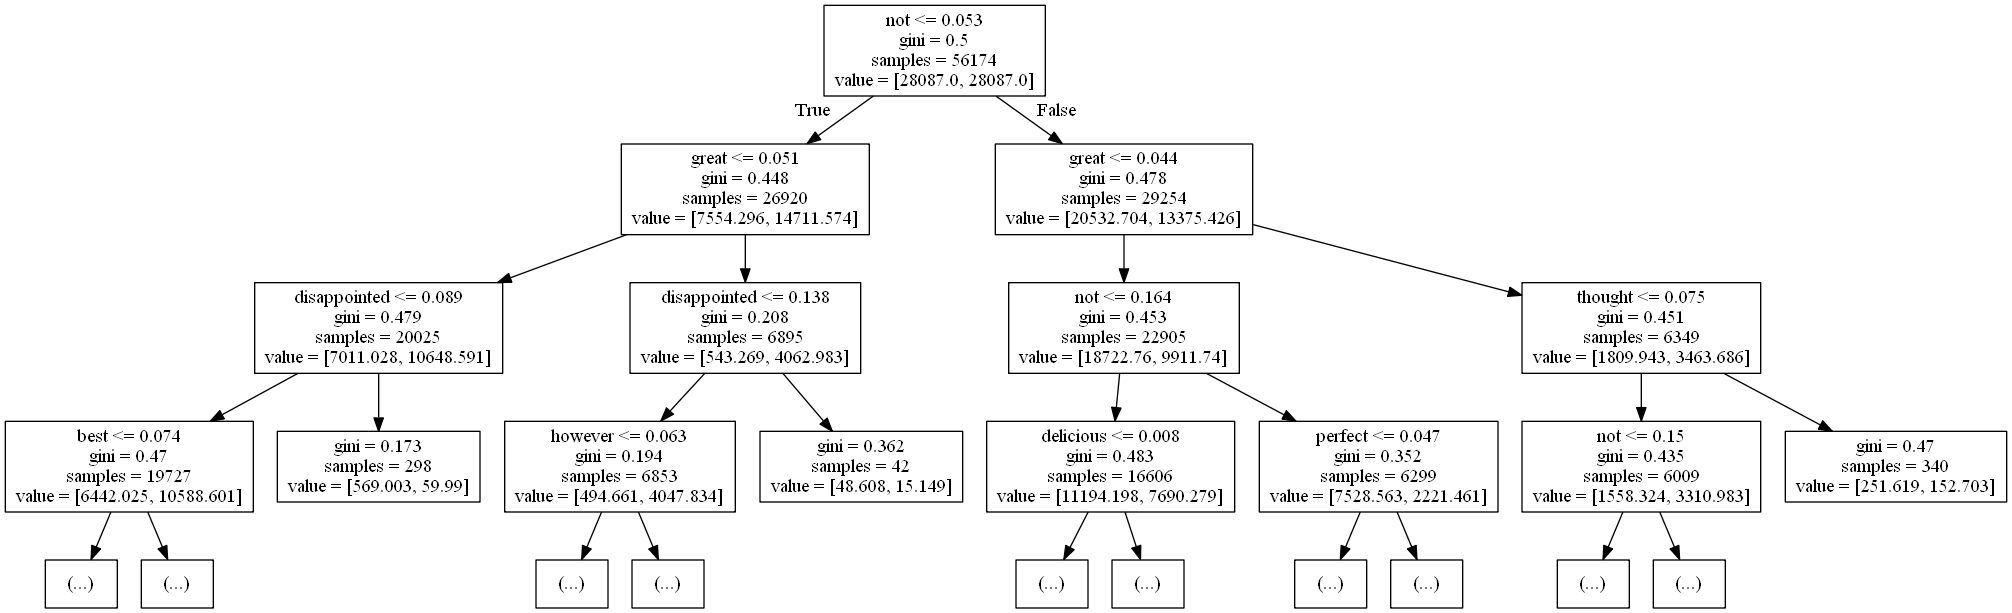

In [153]:
# Create DOT data
dot_data =tree.export_graphviz(decision_tree=DT_tfidf_L2, out_file = None,max_depth=3, feature_names = All_features_tfidf_L2)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())



In [154]:
# Create png

graph.write_png("graphviz_tfidf_L2.png")

True

## Applying Decision Trees on AVG W2V

In [25]:

list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [26]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [27]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [28]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14159
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'partner', 'happy', 'tea', 'feeling', 'much', 'better', 'since', 'starting', 'drink', 'drinking', 'hot', 'normal', 'iced', 'chilled', 'likes', 'refreshing', 'nature', 'chocolate', 'amazing', 'taste', 'smell', 'found', 'new', 'one', 'finest', 'maple', 'syrups', 'ordered', 'enjoyed', 'bought', 'fancy']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [29]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 56174/56174 [02:14<00:00, 416.71it/s]


In [31]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(56174, 50)
[-0.24088348 -0.17217938  0.34458257  0.20901505 -0.46931693 -0.07857027
 -0.81296048  0.50579995  0.00596466 -0.92452358  0.370473   -0.40794242
  0.08881405  0.42022151 -0.48877624  0.57867011  0.01730235  0.32684699
  0.27955227  0.57855617  0.02067689  0.48075995 -0.31932452 -0.91452351
 -0.12489517 -0.02631747 -0.29404973 -0.22143068  0.25592744  1.0772705
 -0.44216881 -0.37517012  0.53841669 -0.16720705  0.45658075  0.43959757
 -0.06443139  0.3200278  -0.07540293 -1.17899164  0.11860835  0.01796186
  0.41246233  0.94001043 -0.28933815  0.66124378  0.74911851  0.48829696
  0.94535648 -0.4713075 ]


## Converting CV data text

In [32]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|███████████████████████████████████████████████████████████████████████████| 14044/14044 [00:34<00:00, 412.40it/s]


In [34]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(14044, 50)
[-0.50765732 -0.32845357 -0.30643425  0.21578251 -0.21921924 -0.55948037
 -0.32738525  0.27241372  0.17067781 -0.02539748  0.19308467 -0.49745558
 -0.01800593  0.73802286 -0.2869965   0.62569017 -0.05939303  0.06368123
  0.20304203 -0.10514853  0.06547124  0.05735426  0.24748137 -0.4848464
  0.48618482  0.82936485 -0.63731182  0.22824947  0.24605437  0.80651089
  0.49601087 -0.46203521  0.51861653 -0.05887693  0.66361143  0.22754054
  0.79428052  0.09016797  0.00471827  0.05311472  0.38804162 -0.42134522
 -0.16701919 -0.1484259  -0.05255342  1.14785023 -0.41527463  0.53198424
 -0.57067103  0.209489  ]


## Converting Test data text

In [36]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:42<00:00, 415.44it/s]


(17555, 50)
[-1.00292558  0.04324219  0.38741096 -0.20215276  0.01019121 -0.79846379
  0.05519976  0.74862369  0.37443852 -0.02302838  0.5252147  -0.15764272
 -0.28680595  0.00694217 -0.85091386  0.68105364 -0.55455128  0.71226953
  0.37711362 -0.60094723 -0.1942199   0.61014393  0.42909409 -1.16092415
  0.05789615 -0.59521893 -0.18687784 -0.14213835  0.6252823   1.02539935
 -0.40508882  0.1657429   0.69093178 -0.20482798 -0.0055846  -0.15096126
  1.16153132  0.19363833  0.16997406 -0.53535903 -0.0082052  -0.25094176
 -0.29031521  0.31010907 -0.4605465   1.15178081 -0.1554725   0.1627589
 -0.22738764  0.40551041]


## Hyperparameter tuning to find best "depth" and 'min_samples_split"' using RandomizedSearchCV

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]
params_grid=dict(max_depth=depth,min_samples_split=min_samples_split)

In [40]:
# Estimator
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced',random_state=5)

In [44]:
# Building RandomizedsSearchCV

DT_RandomCV=RandomizedSearchCV(DT,params_grid,cv=5,n_iter=70,scoring='roc_auc',n_jobs=-1)
DT_RandomCV.fit(sent_vectors_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=5,
                                                    splitter='bes

In [47]:
# Finding best parameters
DT_RandomCV.best_params_

{'min_samples_split': 500, 'max_depth': 10}

## Building Decision Tree using best the parameters

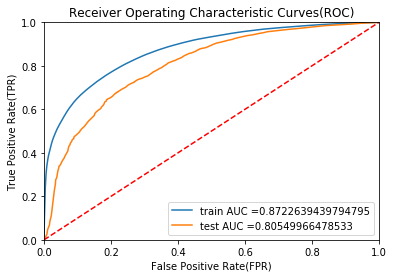

In [48]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced',random_state=2)
DT.fit(sent_vectors_train,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  DT.predict_proba(sent_vectors_train)[:,1]
y_cv_pred =  DT.predict_proba(sent_vectors_cv)[:,1]
y_test_pred=DT.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, DT.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, DT.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting confusion matrix using seaborn

In [49]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [50]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6167914706428572 for threshold 0.496

Train confusion matrix:

[[ 7931  1892]
 [10942 35409]]

Test confusion matrix:

[[ 1484   683]
 [ 3692 11696]]


In [51]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

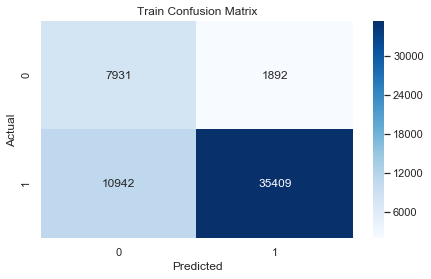

In [52]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

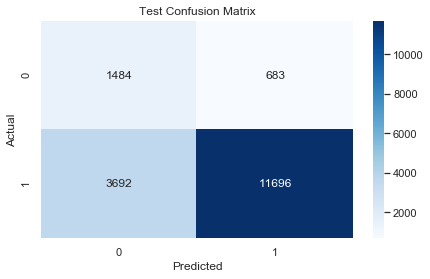

In [53]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Applying Decision Trees on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [54]:
model = TfidfVectorizer(norm='l1')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [55]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [36:00<00:00, 26.00it/s]


In [56]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [57]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(56174, 50)
[-1.34122182e-01 -1.87977637e-01  2.86143294e-01  1.72376146e-01
 -4.49649756e-01 -8.26726459e-02 -8.35226564e-01  3.39047744e-01
  2.49116842e-02 -6.62930672e-01  2.85774624e-01 -3.87977924e-01
  2.51826278e-01  4.54321261e-01 -6.46677735e-01  6.17343771e-01
 -8.70820312e-02  2.96407482e-01  4.94610597e-02  4.39097847e-01
  1.07915378e-01  4.70386234e-01 -3.25521996e-01 -9.31881007e-01
 -2.07344765e-01 -9.27619098e-02 -1.53894055e-01 -5.63802693e-02
  1.88001154e-01  8.69300173e-01 -4.23407714e-01 -3.62257894e-01
  3.46642949e-01 -2.90403967e-01  3.33406098e-01  3.37720257e-01
 -1.81931292e-02  2.86397829e-01  1.13858454e-01 -1.18503347e+00
  1.86698382e-02 -5.85654213e-04  3.55451641e-01  8.64208338e-01
 -1.52110876e-01  4.30637837e-01  6.81718862e-01  5.52177885e-01
  7.97280308e-01 -3.39462916e-01]


## Converting CV data to tfidf-w2v

In [58]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using same dictioanry which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [08:29<00:00, 27.59it/s]


In [59]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [60]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(14044, 50)
[-0.32451702 -0.37879885 -0.59672488  0.21154801 -0.22724102 -0.62177451
 -0.35618379  0.24595046  0.04813326  0.19687833  0.28530184 -0.52988626
  0.0493418   0.90394465 -0.28497446  0.71876355  0.02809051  0.02917751
  0.25650841 -0.01870639 -0.06012093  0.09386846  0.13106105 -0.40374005
  0.35303428  0.834633   -0.54963726  0.39018683  0.32928001  0.80014903
  0.66741774 -0.30457004  0.39693245 -0.1680415   0.84341417  0.35788032
  0.91699622  0.18545899  0.11473545  0.31158035  0.35332794 -0.57610438
 -0.27372568 -0.34563667  0.20892795  1.09103784 -0.37454096  0.46000045
 -0.52396132  0.12708561]


## Converting Test data to tfidf-w2v

In [61]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using the same dictionary which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [10:34<00:00, 21.86it/s]


In [62]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [63]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(17555, 50)
[-1.09830368  0.05567868  0.42790069 -0.23245973  0.09944499 -0.80194011
  0.11058257  0.6666076   0.37939317  0.01033726  0.57953171 -0.25485179
 -0.29437402  0.06864687 -0.83148714  0.64636043 -0.57321291  0.81662938
  0.4280058  -0.65828451 -0.15602646  0.67635672  0.40668076 -1.12377633
  0.11457005 -0.57890863 -0.11133807 -0.01601785  0.56870663  0.89977049
 -0.49887368 -0.01884592  0.62705956 -0.27434293  0.02692884 -0.18147701
  1.05292933  0.21103415  0.29442986 -0.57790131  0.03627283 -0.21939878
 -0.21238767  0.38859658 -0.38424746  0.98686071 -0.06512394  0.06219954
 -0.24696275  0.42707662]


## Hyperparameter tuning to find best "depth" and 'min_samples_split"' using RandomizedSearchCV

In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]
params_grid=dict(max_depth=depth,min_samples_split=min_samples_split)

In [65]:
# Estimator

from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced',random_state=3)

In [69]:
# Building RandomizedsSearchCV

DT_RandomCV=RandomizedSearchCV(DT,params_grid,cv=5,n_iter=100,scoring='roc_auc',n_jobs=-1)
DT_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=3,
                                                    splitter='bes

In [70]:
# Finding best parameters
DT_RandomCV.best_params_

{'min_samples_split': 500, 'max_depth': 10}

## Building Decision Tree using best the parameters

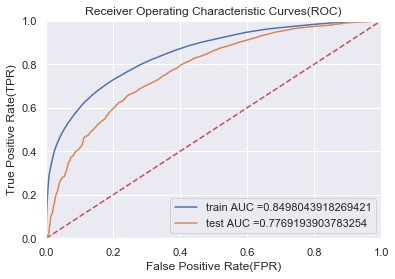

In [72]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced',random_state=6)
DT.fit(tfidf_sent_vectors_train,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  DT.predict_proba(tfidf_sent_vectors_train)[:,1]
y_cv_pred =  DT.predict_proba(tfidf_sent_vectors_cv)[:,1]
y_test_pred=DT.predict_proba(tfidf_sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, DT.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, DT.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



In [73]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.582922067864475 for threshold 0.481

Train confusion matrix:

[[ 7853  1970]
 [12554 33797]]

Test confusion matrix:

[[ 1471   696]
 [ 4319 11069]]


In [74]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

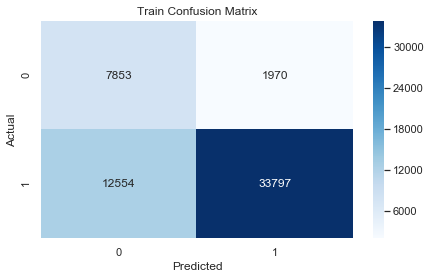

In [75]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

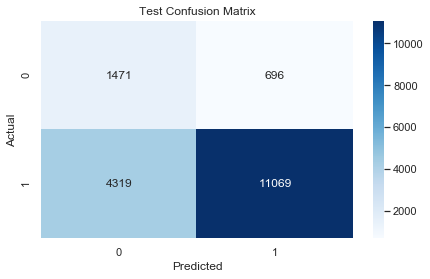

In [76]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Converting Train data to Tfidf_w2v :l2 regularization

In [77]:
model = TfidfVectorizer(norm='l2')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [78]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [34:16<00:00, 27.31it/s]


In [79]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [80]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(56174, 50)
[-1.34122182e-01 -1.87977637e-01  2.86143294e-01  1.72376146e-01
 -4.49649756e-01 -8.26726459e-02 -8.35226564e-01  3.39047744e-01
  2.49116842e-02 -6.62930672e-01  2.85774624e-01 -3.87977924e-01
  2.51826278e-01  4.54321261e-01 -6.46677735e-01  6.17343771e-01
 -8.70820312e-02  2.96407482e-01  4.94610597e-02  4.39097847e-01
  1.07915378e-01  4.70386234e-01 -3.25521996e-01 -9.31881007e-01
 -2.07344765e-01 -9.27619098e-02 -1.53894055e-01 -5.63802693e-02
  1.88001154e-01  8.69300173e-01 -4.23407714e-01 -3.62257894e-01
  3.46642949e-01 -2.90403967e-01  3.33406098e-01  3.37720257e-01
 -1.81931292e-02  2.86397829e-01  1.13858454e-01 -1.18503347e+00
  1.86698382e-02 -5.85654213e-04  3.55451641e-01  8.64208338e-01
 -1.52110876e-01  4.30637837e-01  6.81718862e-01  5.52177885e-01
  7.97280308e-01 -3.39462916e-01]


## Converting CV data to tfidf-w2v

In [81]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [08:06<00:00, 28.88it/s]


In [82]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [83]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(14044, 50)
[-0.32451702 -0.37879885 -0.59672488  0.21154801 -0.22724102 -0.62177451
 -0.35618379  0.24595046  0.04813326  0.19687833  0.28530184 -0.52988626
  0.0493418   0.90394465 -0.28497446  0.71876355  0.02809051  0.02917751
  0.25650841 -0.01870639 -0.06012093  0.09386846  0.13106105 -0.40374005
  0.35303428  0.834633   -0.54963726  0.39018683  0.32928001  0.80014903
  0.66741774 -0.30457004  0.39693245 -0.1680415   0.84341417  0.35788032
  0.91699622  0.18545899  0.11473545  0.31158035  0.35332794 -0.57610438
 -0.27372568 -0.34563667  0.20892795  1.09103784 -0.37454096  0.46000045
 -0.52396132  0.12708561]


## Converting Test data to tfidf-w2v

In [84]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [10:06<00:00, 28.95it/s]


In [85]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [86]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(17555, 50)
[-1.09830368  0.05567868  0.42790069 -0.23245973  0.09944499 -0.80194011
  0.11058257  0.6666076   0.37939317  0.01033726  0.57953171 -0.25485179
 -0.29437402  0.06864687 -0.83148714  0.64636043 -0.57321291  0.81662938
  0.4280058  -0.65828451 -0.15602646  0.67635672  0.40668076 -1.12377633
  0.11457005 -0.57890863 -0.11133807 -0.01601785  0.56870663  0.89977049
 -0.49887368 -0.01884592  0.62705956 -0.27434293  0.02692884 -0.18147701
  1.05292933  0.21103415  0.29442986 -0.57790131  0.03627283 -0.21939878
 -0.21238767  0.38859658 -0.38424746  0.98686071 -0.06512394  0.06219954
 -0.24696275  0.42707662]


## Hyperparameter tuning to find best "depth" and 'min_samples_split"' using RandomizedSearchCV

In [87]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]
params_grid=dict(max_depth=depth,min_samples_split=min_samples_split)

In [88]:
# Estimator

from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced',random_state=7)

In [89]:
# Building RandomizedsSearchCV

DT_RandomCV=RandomizedSearchCV(DT,params_grid,cv=5,n_iter=100,scoring='roc_auc',n_jobs=-1)
DT_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=7,
                                                    splitter='bes

In [90]:
# Finding best parameters
DT_RandomCV.best_params_

{'min_samples_split': 500, 'max_depth': 10}

## Building Decision Tree using best the parameters

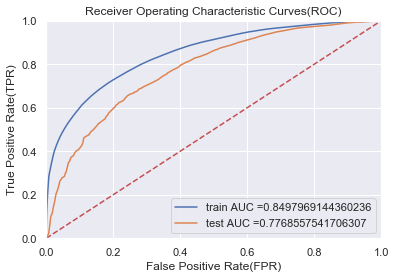

In [92]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced',random_state=2)
DT.fit(tfidf_sent_vectors_train,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  DT.predict_proba(tfidf_sent_vectors_train)[:,1]
y_cv_pred =  DT.predict_proba(tfidf_sent_vectors_cv)[:,1]
y_test_pred=DT.predict_proba(tfidf_sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, DT.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, DT.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



In [93]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.5828582975471525 for threshold 0.481

Train confusion matrix:

[[ 7854  1969]
 [12562 33789]]

Test confusion matrix:

[[ 1471   696]
 [ 4323 11065]]


In [94]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

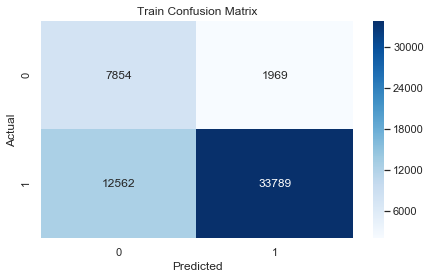

In [95]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

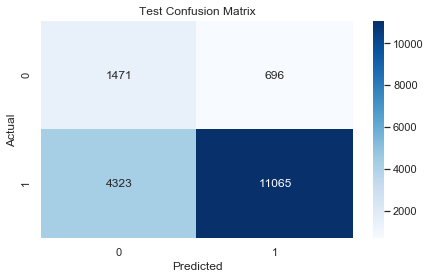

In [96]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

# Conclusions

In [115]:
from prettytable import PrettyTable

In [116]:
x=PrettyTable()

In [117]:
x.field_names=['Vectorizer','Regularization','min_samples_split','max_depth','AUC']

In [118]:
x.add_row(['BOW','-',500,50,81.14])
x.add_row(['TFIDF','L1',500,50,78.64])
x.add_row(['TFIDF','L2',500,50,79.13])
x.add_row(['AVGW2V','-',500,10,80.54])
x.add_row(['TFIDF_AVGW2V','L1',500,10,79.69])
x.add_row(['TFIDF_AVGW2V','L2',500,10,79.68])

In [119]:
print(x)

+--------------+----------------+-------------------+-----------+-------+
|  Vectorizer  | Regularization | min_samples_split | max_depth |  AUC  |
+--------------+----------------+-------------------+-----------+-------+
|     BOW      |       -        |        500        |     50    | 81.14 |
|    TFIDF     |       L1       |        500        |     50    | 78.64 |
|    TFIDF     |       L2       |        500        |     50    | 79.13 |
|    AVGW2V    |       -        |        500        |     10    | 80.54 |
| TFIDF_AVGW2V |       L1       |        500        |     10    | 79.69 |
| TFIDF_AVGW2V |       L2       |        500        |     10    | 79.68 |
+--------------+----------------+-------------------+-----------+-------+
